# CNN Explainability with Grad-CAM

Authors: Rohan Subramanian, Sahil Rane and Forrest Bicker

In this notebook, we apply interpretability methods such as Grad-CAM to the ResNet34 model fine-tuned on CIFAR-10 in train.ipynb.

We used the pytorch-gradcam package and <a href='https://jacobgil.github.io/pytorch-gradcam-book/introduction.html'>associated tutorials</a> written by Jacob Gildenblat.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
import torch.nn as nn

from torchvision import transforms
import torchvision
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

from datasets import load_dataset
from transformers import ViTImageProcessor

In [18]:
# load cifar10 (only small portion for demonstration purposes)
train_ds, test_ds = load_dataset('cifar10', split=['train[:5000]', 'test[:2000]'])

# split up training into training + validation
splits = train_ds.train_test_split(test_size=0.1, seed=42)
train_ds = splits['train']

val_ds = splits['test']
from torchvision.transforms import (CenterCrop,
                                    Compose,
                                    Normalize,
                                    RandomHorizontalFlip,
                                    RandomResizedCrop,
                                    Resize,
                                    ToTensor, InterpolationMode)

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            Resize(size, interpolation=InterpolationMode.NEAREST_EXACT),
            RandomHorizontalFlip(),
            ToTensor()
        ]
    )

_val_transforms = Compose(
        [
            Resize(size, interpolation=InterpolationMode.NEAREST_EXACT),
            CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

class CIFAR10TorchvisionDataset:
  def __init__(self, transformer_dataset):
    self.transformer_dataset = transformer_dataset

  def __getitem__(self, i):
    elem = self.transformer_dataset.__getitem__(i)
    return (_train_transforms(elem['img']), elem['label'])

  def __len__(self):
    return len(self.transformer_dataset)

train_dataset = CIFAR10TorchvisionDataset(train_ds)
train_dataloader = DataLoader(CIFAR10TorchvisionDataset(train_ds), batch_size=8)
valid_dataloader = DataLoader(CIFAR10TorchvisionDataset(val_ds), batch_size=8)
test_dataloader = DataLoader(CIFAR10TorchvisionDataset(test_ds), batch_size=8)

In [19]:
model = torch.load('./models/resnet_cifar10')
device = "cuda"

In [20]:
target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

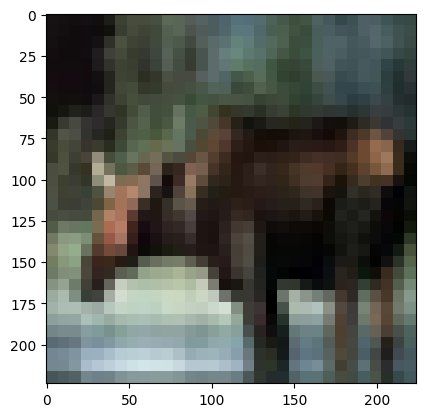

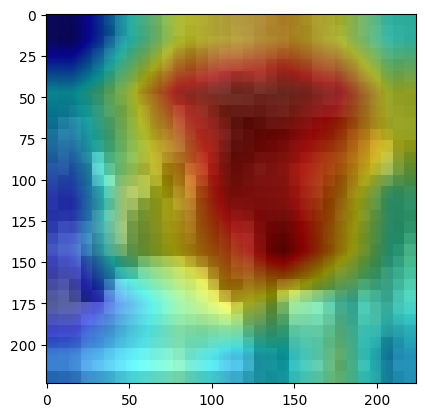

In [27]:
import numpy as np
from matplotlib import pyplot as plt
import torchvision.transforms.functional as F
import random

img = train_dataset[random.randint(0, 1000)][0]
input_tensor = img.unsqueeze(0).to(device)
grayscale_cam = cam(input_tensor)

# Convert to NumPy array and rearrange dimensions thenn plot
image_np = np.transpose(F.to_pil_image(img), (0, 1, 2))
plt.imshow(image_np, interpolation='none')
plt.show()


im = np.transpose(np.array(img), (1, 2, 0))
visualization = show_cam_on_image(im, grayscale_cam[0, :], use_rgb=True)
plt.imshow(visualization, interpolation='nearest')
plt.show()

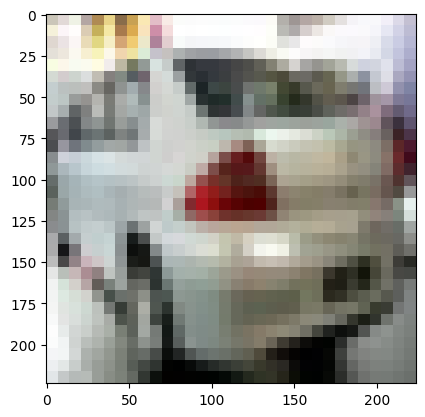

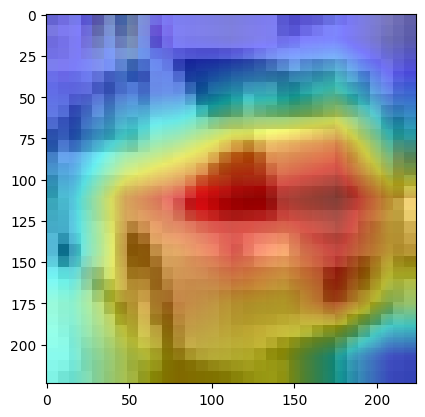

In [28]:
import numpy as np
from matplotlib import pyplot as plt
import torchvision.transforms.functional as F
import random

img = train_dataset[random.randint(0, 1000)][0]
input_tensor = img.unsqueeze(0).to(device)
grayscale_cam = cam(input_tensor)

# Convert to NumPy array and rearrange dimensions thenn plot
image_np = np.transpose(F.to_pil_image(img), (0, 1, 2))
plt.imshow(image_np, interpolation='none')
plt.show()


im = np.transpose(np.array(img), (1, 2, 0))
visualization = show_cam_on_image(im, grayscale_cam[0, :], use_rgb=True)
plt.imshow(visualization, interpolation='nearest')
plt.show()